No training; Use empirical distribution to replace score function;

1. Load 1 image;
2. Compute empirical distribution, at time t;
3. Loop from T to 0 to generate;

Load an image as HWC, (C=3). Use $x^i(k)$ for k-th pixel of i-th image in dataset; 

$$
\begin{align}
\begin{aligned}
    p(x,t) &= \int_\mathbb{R} p(x,t|x^i,0) \pi_0(dx)\\
           &= \frac{1}{N} \sum_{i=1}^{N} p(x,t|x^i,0)
\end{aligned}
\end{align}
$$

Assume noise on each pixel are iid Gaussian,

$$
\begin{align}
\begin{aligned}
    p(x,t|x^i,0)&:=\prod_{k} \frac{1}{\sqrt{2\pi} \bar{\beta}_t} \exp\left\{ \frac{(x(k)-x^i(k))^2}{-2 \bar{\beta}_t^2}\right\}
\end{aligned}
\end{align}
$$

following 

$$
x_t = \bar{\alpha}_t x_0 + \bar{\beta}_t \bar{\varepsilon}_t,~ \varepsilon_t \sim \mathcal{N}(0,I)\\
$$

if we take $x_0:=x^i$ and $x_t=x$.

Case $N=1$, ${x^i}_{i=0}^{N}={x^0}$,
$$\begin{align}
\begin{aligned}
\log p(x,t) &= \log (x,t|x^0,0)\\
       &= \sum_{k} - \log(\sqrt{2\pi} \bar{\beta}_t)＋　\frac{(x(k)-\bar{\alpha}_t x^0(k))^2}{-2\bar{\beta}_t^2}\\

\frac{\partial}{\partial {x(k)}} \log p(x,t) &= -\frac{1}{\bar{\beta}_t^2} (x(k) - \bar{\alpha}_t x^0(k))\\
\end{aligned}
\end{align}
$$

The reverse SDE:

$$
\begin{align}
\left\{
    \begin{aligned}
    d\bar{X}(t) = \frac{\partial}{\partial x} \log p(\bar{X}(t), 1-t)dt + \bar{W}(t)\\
    \bar{X}(0) \sim p(x,1) = \mathcal{N}(0,I), ~ t \in [0,1]\\
\end{aligned}\right.
\end{align}
$$

Then the sampling:

$$
\begin{align}
\left\{ \begin{aligned}
    \bar{x}_{t-1}:= \frac{\partial}{\partial x} \log p(\bar{x}_t,t) + \sigma_t z, ~ z \sim \mathcal{N}(0,I),\\
    \sigma = \beta_t.
\end{aligned} \right.
\end{align}
$$

In [51]:
import numpy as np
from MyDDPM.apps.rennet import call_by_inspect
img_size = 128  # 如果只想快速实验，可以改为64


# 超参数选择
T = 100000
alpha = np.sqrt(1 - 0.02 * np.arange(1, T + 1) / T)
beta = np.sqrt(1 - alpha**2)
bar_alpha = np.cumprod(alpha)
bar_beta = np.sqrt(1 - bar_alpha**2)
sigma = beta.copy()

config = dict(locals())

In [52]:
from MyDDPM.apps.ddpm2 import get_imgs

imgs = get_imgs(["CelebAHQ256_1"])
print("- imgs: ")
print(len(imgs))
print(imgs[0])

- imgs: 
64
/home/tjrym/workspace/Dataset/CelebAHQ_1/00001 (11).jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


- x0
(128, 128, 3)
-1.0 0.94509804


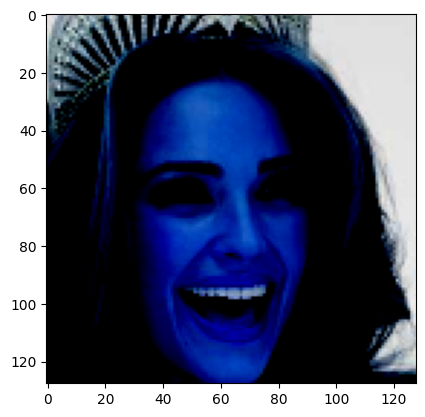

In [53]:
from MyDDPM.apps.ddpm2_h import imread
from matplotlib import pyplot as plt
x0 = imread(imgs[0],img_size)

print("- x0")
print(x0.shape)
print(x0.min(),x0.max())
plt.imshow(x0)
plt.show()



The SDE:
$$
\begin{align}
\left\{ \begin{aligned}
dX(t) = dW(t),\\
X(0) = \text{image}\\

\end{aligned}\right.
\end{align}
$$

Notice here $X(1) = \mathcal(X(0),I)$, denoted as $X(1) \sim p(x,1)$.

Later we will derive a version of $X(1) \sim \mathcal(0,I)$, which is'ore close to original DDPM. Since we compute score function based on Data, so sampling start from a dist related to data is OK.
The reverse SDE, $t \in [0,1]$:

$$
\begin{align}
\left\{
    \begin{aligned}
    d\bar{X}(t) = \frac{\partial}{\partial x} \log p(\bar{X}(t), 1-t)dt + \bar{W}(t)\\
    \bar{X}(0) \sim p(x,1) = \mathcal{N}(0,I), ~ t \in [0,1]\\
\end{aligned}\right.
\end{align}
$$

Transition:
$$
p(x,t|x',t') = \frac{1}{\sqrt{2 \pi (t-t')}}\exp\left(\frac{(x-x')^2}{-2(t-t')}\right),~ t>t'
$$ 
i.e.,
$$
x = x' + \sqrt{t-t'}\varepsilon,~ \varepsilon \sim\mathcal{N}(0,1)
$$


Case $N=1$, ${x^i}_{i=0}^{N}={x^0}$,i.e., $x'=x^0$ and $t'=0$
$$
\begin{align}
p(x,t)= p(x,t|x^0,0) = \frac{1}{\sqrt{2 \pi t}}\exp\left(\frac{(x-x^0)^2}{-2t}\right)\\
\log p(x,t) = \frac{(x-x^0)}{-t}
\end{align}
$$


The sampling, for $t=0,1/T,2/T,\cdots,(T-1)/T$:

$$
\begin{align}
\left\{ \begin{aligned}
    \bar{x}(t+1/T) :=\bar{x}(t) -\frac{x(t)-x^0}{1-t} + \sqrt{1-t} \bar{\varepsilon}(t),~ \bar{\varepsilon}(t) \sim \mathcal{N}(0,I)\\
    \bar{x}(0) \sim \mathcal{N}(0,I)
\end{aligned} \right.
\end{align}
$$

then $\bar{x}_T \approx \bar{x}(1)$ is a new image;  

BUT IS theorictially WRONG. bar_x(1) should be p(x,1)=N(x^0,1), but not N(0,1). Though the latter works in algorithm ... ...

100% 2000/2000 [00:02<00:00, 903.42it/s]


- T= 2000
- y0 min/max:  -1.0 0.986255938635338
- mse:  0.0004971503234575274
Human friendly (RGB)


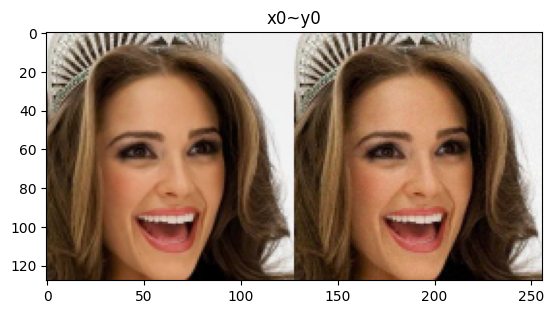

In [87]:
from tqdm import tqdm
def sample(x0,T,n):
    
    y_states = []
    y = np.random.randn(n, img_size, img_size, 3) # xT
    x0 = x0[np.newaxis,:]
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  -(y-x0)/(1-t_old)
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        y_states.append(y)
        t_old = t
    
    return y_states

from matplotlib import pyplot as plt
import cv2

def run_1(x0, T, n, n_show,*,nodisp=False):
    assert n_show<=n
    y_states = sample(x0, T=T , n=n)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0 min/max: ", y0.min(), y0.max())
    err = np.sum((y0-x0)**2)/y0.size
    print("- mse: ", err)
    
    if n_show>0:
        rows = []
        for i in range(n_show):
            # plt.figure()
            # plt.title("BGR(cv2 default)")
            # plt.imshow(y0[i])
            # plt.show()
            row = np.concatenate([
            cv2.cvtColor((x0+1)/2, cv2.COLOR_BGR2RGB),
            cv2.cvtColor((y0[i].astype("float32")+1)/2, cv2.COLOR_BGR2RGB)
            ],axis=1)
            rows.append(row)
        figure = np.concatenate(rows,axis=0)

    
        from matplotlib import pyplot as plt
        print("Human friendly (RGB)")
        plt.figure()
        plt.title("x0~y0")
        plt.imshow(figure)
        if not nodisp:
            plt.show()
        else:
            plt.close()

    return y_states, err

_ = run_1(x0,T=2000,n=2,n_show=1)


100% 100/100 [00:00<00:00, 209.69it/s]


- T= 100
- y0 min/max:  -1.0 1.0
- mse:  0.009447442325964379


100% 200/200 [00:00<00:00, 212.80it/s]


- T= 200
- y0 min/max:  -1.0 1.0
- mse:  0.0048456753707800644


100% 300/300 [00:01<00:00, 217.03it/s]


- T= 300
- y0 min/max:  -1.0 1.0
- mse:  0.0032557984452727413


100% 400/400 [00:01<00:00, 212.33it/s]


- T= 400
- y0 min/max:  -1.0 1.0
- mse:  0.002443229007535604


100% 500/500 [00:02<00:00, 216.38it/s]


- T= 500
- y0 min/max:  -1.0 1.0
- mse:  0.0019623013528378115


100% 600/600 [00:02<00:00, 212.62it/s]


- T= 600
- y0 min/max:  -1.0 1.0
- mse:  0.0016425155696115467


100% 700/700 [00:03<00:00, 217.43it/s]


- T= 700
- y0 min/max:  -1.0 1.0
- mse:  0.0014059270894598434


100% 800/800 [00:03<00:00, 212.51it/s]


- T= 800
- y0 min/max:  -1.0 1.0
- mse:  0.001235081155756449


100% 900/900 [00:04<00:00, 214.82it/s]


- T= 900
- y0 min/max:  -1.0 1.0
- mse:  0.0011001848180643848


100% 1000/1000 [00:04<00:00, 213.04it/s]


- T= 1000
- y0 min/max:  -1.0 1.0
- mse:  0.0009898823914448606


100% 1100/1100 [00:05<00:00, 215.42it/s]


- T= 1100
- y0 min/max:  -1.0 1.0
- mse:  0.0008979811249477574


100% 1200/1200 [00:05<00:00, 212.45it/s]


- T= 1200
- y0 min/max:  -1.0 1.0
- mse:  0.0008252408760487544


100% 1300/1300 [00:06<00:00, 216.51it/s]


- T= 1300
- y0 min/max:  -1.0 1.0
- mse:  0.0007593868190569137


100% 1400/1400 [00:06<00:00, 212.07it/s]


- T= 1400
- y0 min/max:  -1.0 1.0
- mse:  0.0007066685067722609


100% 1500/1500 [00:06<00:00, 214.61it/s]


- T= 1500
- y0 min/max:  -1.0 1.0
- mse:  0.0006591406970861956


100% 1600/1600 [00:07<00:00, 212.36it/s]


- T= 1600
- y0 min/max:  -1.0 1.0
- mse:  0.0006198807065386553


100% 1700/1700 [00:07<00:00, 215.83it/s]


- T= 1700
- y0 min/max:  -1.0 1.0
- mse:  0.0005811812735705942


100% 1800/1800 [00:08<00:00, 211.86it/s]


- T= 1800
- y0 min/max:  -1.0 0.9997436963259533
- mse:  0.0005506263563476005


100% 1900/1900 [00:08<00:00, 216.80it/s]


- T= 1900
- y0 min/max:  -1.0 0.990786623723943
- mse:  0.0005220717316141609


100% 2000/2000 [00:09<00:00, 211.68it/s]


- T= 2000
- y0 min/max:  -1.0 1.0
- mse:  0.0004942836971658381


100% 2100/2100 [00:09<00:00, 216.27it/s]


- T= 2100
- y0 min/max:  -1.0 1.0
- mse:  0.00047371935352369035


100% 2200/2200 [00:10<00:00, 214.44it/s]


- T= 2200
- y0 min/max:  -1.0 1.0
- mse:  0.0004502564321551522


100% 2300/2300 [00:10<00:00, 215.94it/s]


- T= 2300
- y0 min/max:  -1.0 0.9885951627866457
- mse:  0.00043153526860471706


100% 2400/2400 [00:11<00:00, 211.84it/s]


- T= 2400
- y0 min/max:  -1.0 0.9842858127644387
- mse:  0.00041413101813729997


100% 2500/2500 [00:11<00:00, 216.72it/s]


- T= 2500
- y0 min/max:  -1.0 0.9981658989070293
- mse:  0.0003986786538088285


100% 2600/2600 [00:12<00:00, 211.19it/s]


- T= 2600
- y0 min/max:  -1.0 0.9927766583886352
- mse:  0.00038160430756440863


100% 2700/2700 [00:12<00:00, 216.08it/s]


- T= 2700
- y0 min/max:  -1.0 0.9944788675882142
- mse:  0.00036722052488888396


100% 2800/2800 [00:13<00:00, 211.95it/s]


- T= 2800
- y0 min/max:  -1.0 1.0
- mse:  0.00035457323687197273


100% 2900/2900 [00:13<00:00, 216.49it/s]


- T= 2900
- y0 min/max:  -1.0 0.9774207000457004
- mse:  0.00034249807402567605


100% 3000/3000 [00:14<00:00, 212.28it/s]


- T= 3000
- y0 min/max:  -1.0 0.9835092129498096
- mse:  0.0003312200375359947


100% 3100/3100 [00:14<00:00, 216.31it/s]


- T= 3100
- y0 min/max:  -1.0 0.978680314660082
- mse:  0.00031873662100459217


100% 3200/3200 [00:15<00:00, 211.77it/s]


- T= 3200
- y0 min/max:  -1.0 0.9860554060228865
- mse:  0.00031026499912081574


100% 3300/3300 [00:15<00:00, 215.58it/s]


- T= 3300
- y0 min/max:  -1.0 0.9846099592558216
- mse:  0.00030042737158277104


100% 3400/3400 [00:16<00:00, 212.29it/s]


- T= 3400
- y0 min/max:  -1.0 0.9858748623780973
- mse:  0.00029211038181295023


100% 3500/3500 [00:16<00:00, 216.27it/s]


- T= 3500
- y0 min/max:  -1.0 0.9699371484728647
- mse:  0.00028221831843303015


100% 3600/3600 [00:16<00:00, 211.81it/s]


- T= 3600
- y0 min/max:  -1.0 0.9722086966460884
- mse:  0.0002755094933895292


100% 3700/3700 [00:17<00:00, 215.94it/s]


- T= 3700
- y0 min/max:  -1.0 0.9717764566535902
- mse:  0.0002679130536428074


100% 3800/3800 [00:17<00:00, 211.69it/s]


- T= 3800
- y0 min/max:  -1.0 0.9854216016067403
- mse:  0.00026056161689499307


100% 3900/3900 [00:18<00:00, 214.40it/s]


- T= 3900
- y0 min/max:  -1.0 0.9845791823288932
- mse:  0.00025536010801437137


100% 4000/4000 [00:19<00:00, 209.69it/s]


- T= 4000
- y0 min/max:  -1.0 0.9830849484789808
- mse:  0.00024848563834118823


100% 4100/4100 [00:18<00:00, 216.54it/s]


- T= 4100
- y0 min/max:  -1.0 0.980263303912609
- mse:  0.00024217947742780522


100% 4200/4200 [00:19<00:00, 211.75it/s]


- T= 4200
- y0 min/max:  -1.0 0.9815966836723755
- mse:  0.00023652583059470284


100% 4300/4300 [00:19<00:00, 216.63it/s]


- T= 4300
- y0 min/max:  -1.0 0.9785949863187788
- mse:  0.0002312770265850727


100% 4400/4400 [00:20<00:00, 212.42it/s]


- T= 4400
- y0 min/max:  -1.0 0.969473997195032
- mse:  0.0002261926209373575


100% 4500/4500 [00:20<00:00, 216.72it/s]


- T= 4500
- y0 min/max:  -1.0 0.9693018179134296
- mse:  0.00022061653109353946


100% 4600/4600 [00:21<00:00, 212.40it/s]


- T= 4600
- y0 min/max:  -1.0 0.9753743966056039
- mse:  0.00021628980411098116


100% 4700/4700 [00:21<00:00, 216.25it/s]


- T= 4700
- y0 min/max:  -1.0 0.9710318186159735
- mse:  0.00021137840714908094


100% 4800/4800 [00:22<00:00, 212.19it/s]


- T= 4800
- y0 min/max:  -1.0 0.9726760884853703
- mse:  0.0002066171554660444


100% 4900/4900 [00:22<00:00, 216.72it/s]


- T= 4900
- y0 min/max:  -1.0 0.9770132073811852
- mse:  0.0002031946774199655


100% 5000/5000 [00:23<00:00, 212.59it/s]


- T= 5000
- y0 min/max:  -1.0 0.9760541954015942
- mse:  0.00019785868921968453


100% 5100/5100 [00:23<00:00, 216.20it/s]


- T= 5100
- y0 min/max:  -1.0 0.9954647682181018
- mse:  0.00019502073577284905


100% 5200/5200 [00:24<00:00, 212.19it/s]


- T= 5200
- y0 min/max:  -1.0 0.9693108740027891
- mse:  0.00019156272476436207


100% 5300/5300 [00:24<00:00, 216.84it/s]


- T= 5300
- y0 min/max:  -1.0 0.9725330613452364
- mse:  0.00018716747854816073


100% 5400/5400 [00:25<00:00, 213.00it/s]


- T= 5400
- y0 min/max:  -1.0 0.9653384434107977
- mse:  0.0001848233978178288


100% 5500/5500 [00:25<00:00, 217.29it/s]


- T= 5500
- y0 min/max:  -1.0 0.9771709254011358
- mse:  0.00018039985811107737


100% 5600/5600 [00:26<00:00, 214.06it/s]


- T= 5600
- y0 min/max:  -1.0 0.9743355203324382
- mse:  0.000178023175310623


100% 5700/5700 [00:26<00:00, 217.54it/s]


- T= 5700
- y0 min/max:  -1.0 0.9675057249690724
- mse:  0.00017432109263674158


100% 5800/5800 [00:27<00:00, 213.31it/s]


- T= 5800
- y0 min/max:  -1.0 0.9839456445079695
- mse:  0.00017122439608145497


100% 5900/5900 [00:28<00:00, 210.50it/s]


- T= 5900
- y0 min/max:  -1.0 0.9767569358968549
- mse:  0.0001684047237989779


100% 6000/6000 [00:27<00:00, 218.27it/s]


- T= 6000
- y0 min/max:  -1.0 0.9722790849951981
- mse:  0.0001651137693996936


100% 6100/6100 [00:27<00:00, 218.33it/s]


- T= 6100
- y0 min/max:  -1.0 0.9673393145779813
- mse:  0.0001630097376060398


100% 6200/6200 [00:28<00:00, 217.96it/s]


- T= 6200
- y0 min/max:  -1.0 0.9768122160366013
- mse:  0.00016103325815971674


100% 6300/6300 [00:29<00:00, 212.28it/s]


- T= 6300
- y0 min/max:  -1.0 0.9746906335973107
- mse:  0.00015785101820458896


100% 6400/6400 [00:29<00:00, 217.47it/s]


- T= 6400
- y0 min/max:  -1.0 0.9630587506410007
- mse:  0.00015496378099121475


100% 6500/6500 [00:29<00:00, 217.78it/s]


- T= 6500
- y0 min/max:  -1.0 0.9666178415602078
- mse:  0.0001533824198788796


100% 6600/6600 [00:30<00:00, 217.33it/s]


- T= 6600
- y0 min/max:  -1.0 0.9681535207737696
- mse:  0.00015048345498472693


100% 6700/6700 [00:31<00:00, 212.96it/s]


- T= 6700
- y0 min/max:  -1.0 0.9669652432698931
- mse:  0.0001483591750422734


100% 6800/6800 [00:31<00:00, 218.44it/s]


- T= 6800
- y0 min/max:  -1.0 0.978093120873861
- mse:  0.00014658012430537935


100% 6900/6900 [00:31<00:00, 218.40it/s]


- T= 6900
- y0 min/max:  -1.0 0.967984852567889
- mse:  0.00014450897103860232


100% 7000/7000 [00:32<00:00, 218.12it/s]


- T= 7000
- y0 min/max:  -1.0 0.9752327402106844
- mse:  0.0001423883232852922


100% 7100/7100 [00:33<00:00, 213.01it/s]


- T= 7100
- y0 min/max:  -1.0 0.9670473280712646
- mse:  0.0001397401031417815


100% 7200/7200 [00:32<00:00, 218.39it/s]


- T= 7200
- y0 min/max:  -1.0 0.9647372938583048
- mse:  0.00013787985275915356


100% 7300/7300 [00:33<00:00, 217.67it/s]


- T= 7300
- y0 min/max:  -1.0 0.963941173823078
- mse:  0.00013650950853397485


100% 7400/7400 [00:33<00:00, 218.31it/s]


- T= 7400
- y0 min/max:  -1.0 0.9647118304647743
- mse:  0.00013426462282928903


100% 7500/7500 [00:35<00:00, 212.64it/s]


- T= 7500
- y0 min/max:  -1.0 0.9704912308583126
- mse:  0.00013315314084670873


100% 7600/7600 [00:34<00:00, 217.99it/s]


- T= 7600
- y0 min/max:  -1.0 0.9775287869613405
- mse:  0.00013065255578971065


100% 7700/7700 [00:35<00:00, 218.28it/s]


- T= 7700
- y0 min/max:  -1.0 0.9819582607507595
- mse:  0.0001295229383302439


100% 7800/7800 [00:35<00:00, 218.54it/s]


- T= 7800
- y0 min/max:  -1.0 0.9619274775185475
- mse:  0.00012728724512504953


100% 7900/7900 [00:37<00:00, 213.01it/s]


- T= 7900
- y0 min/max:  -1.0 0.9704437661949971
- mse:  0.00012628754610763418


100% 8000/8000 [00:36<00:00, 218.09it/s]


- T= 8000
- y0 min/max:  -1.0 0.9663245613317021
- mse:  0.00012425215671052378


100% 8100/8100 [00:37<00:00, 217.95it/s]


- T= 8100
- y0 min/max:  -1.0 0.9645540707275477
- mse:  0.0001229631338362118


100% 8200/8200 [00:37<00:00, 217.71it/s]


- T= 8200
- y0 min/max:  -1.0 0.9667295854271111
- mse:  0.00012125214851587551


100% 8300/8300 [00:39<00:00, 211.25it/s]


- T= 8300
- y0 min/max:  -1.0 0.9663181766465526
- mse:  0.00011966919125214854


100% 8400/8400 [00:38<00:00, 219.64it/s]


- T= 8400
- y0 min/max:  -1.0 0.9765668439866738
- mse:  0.00011848124385154337


100% 8500/8500 [00:38<00:00, 220.31it/s]


- T= 8500
- y0 min/max:  -1.0 0.9621927843234231
- mse:  0.00011721829879695775


100% 8600/8600 [00:39<00:00, 220.00it/s]


- T= 8600
- y0 min/max:  -1.0 0.96772905929819
- mse:  0.00011546082611340275


100% 8700/8700 [00:40<00:00, 214.83it/s]


- T= 8700
- y0 min/max:  -1.0 0.960364392360171
- mse:  0.00011450679123494152


100% 8800/8800 [00:39<00:00, 220.30it/s]


- T= 8800
- y0 min/max:  -1.0 0.9605961835194871
- mse:  0.00011318998031096225


100% 8900/8900 [00:40<00:00, 221.00it/s]


- T= 8900
- y0 min/max:  -1.0 0.958376716288319
- mse:  0.00011172929122424932


100% 9000/9000 [00:40<00:00, 220.42it/s]


- T= 9000
- y0 min/max:  -1.0 0.9612313089722886
- mse:  0.00011033245444393214


100% 9100/9100 [00:42<00:00, 214.80it/s]


- T= 9100
- y0 min/max:  -1.0 0.9602428854822519
- mse:  0.00010882278110282692


100% 9200/9200 [00:41<00:00, 220.74it/s]


- T= 9200
- y0 min/max:  -1.0 0.964649814801667
- mse:  0.00010815391723612547


100% 9300/9300 [00:42<00:00, 219.89it/s]


- T= 9300
- y0 min/max:  -1.0 0.9607635360763821
- mse:  0.00010678382623704163


100% 9400/9400 [00:42<00:00, 220.58it/s]


- T= 9400
- y0 min/max:  -1.0 0.9650764183450546
- mse:  0.00010632561312012971


100% 9500/9500 [00:44<00:00, 215.44it/s]


- T= 9500
- y0 min/max:  -1.0 0.9664274097395973
- mse:  0.00010489518235325876


100% 9600/9600 [00:43<00:00, 220.85it/s]


- T= 9600
- y0 min/max:  -1.0 0.966845599705856
- mse:  0.00010383118866604312


100% 9700/9700 [00:43<00:00, 220.61it/s]


- T= 9700
- y0 min/max:  -1.0 0.9668835819757405
- mse:  0.00010223669329724846


100% 9800/9800 [00:44<00:00, 220.66it/s]


- T= 9800
- y0 min/max:  -1.0 0.9601810162821237
- mse:  0.00010221719416672088


100% 9900/9900 [00:47<00:00, 209.74it/s]


- T= 9900
- y0 min/max:  -1.0 0.9636049218597218
- mse:  0.00010039557999101704


100% 10000/10000 [00:46<00:00, 214.94it/s]

- T= 10000
- y0 min/max:  -1.0 0.9772481875344557
- mse:  9.930640528802614e-05


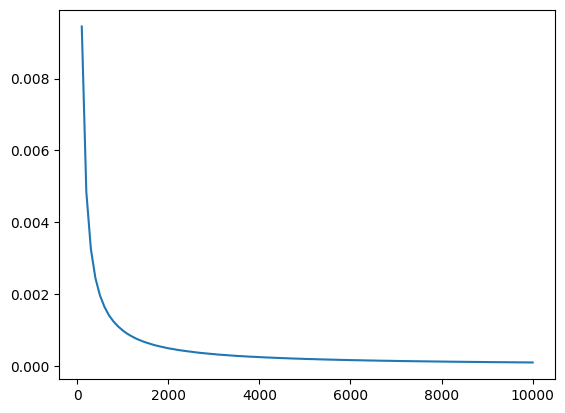

In [88]:
count = 100
step = 100
T_l =[(j+1)*step for j in range(count)]
err_l = []
for j,T in enumerate(T_l):
    _,err = run_1(x0,T=T,n=8,n_show=0)
    err_l.append(err)

plt.figure()
plt.plot(T_l, err_l)

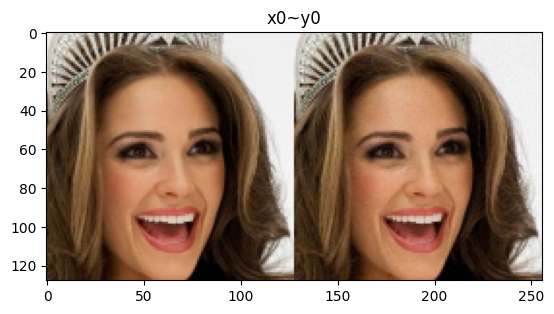


from tqdm import tqdm

def score_func_1(x,t,x0,*,bar_alpha, bar_beta, T):
    bb = bar_beta[t]
    ba = bar_alpha[t]
    sc = -1/bb/bb *(x - ba*x0)
    return sc

def sample(x0,*,img_size, sigma, bar_alpha, bar_beta,T, t0=0):
    y = np.random.randn(img_size, img_size, 3) # xT
    for t in tqdm(range(t0, T), ncols=0):
        t = T - t - 1
        # sf = model.predict([z_samples, bt])
        sf = score_func_1(y,t,x0,bar_alpha=bar_alpha, bar_beta=bar_beta, T=T)
        y -= beta[t]**2 / bar_beta[t] * sf
        y /= alpha[t]
        y += np.random.randn(*y.shape) * sigma[t]
    y0 = np.clip(y, -1, 1)

    return y0

y0 = call_by_inspect( sample, config, x0=x0, t0=0)
print("- y0:")
print(y0.min(),y0.max())
err = np.sum((x0-y0)**2)
print(err)
from matplotlib import pyplot as plt
plt.imshow(y0)
plt.show()

66353.24828810083
